<a href="https://colab.research.google.com/github/danielm322/Signal-Processing/blob/main/Project%20Social%20Sparsity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt install libfftw3-dev > /dev/null
!apt install liblapack-dev > /dev/null
!pip install ltfatpy > /dev/null

In [ ]:
# Cell only useful in Colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from scipy import signal
from IPython.display import Audio
import scipy.signal as sig
from tqdm import tqdm
from scipy import optimize
# from scipy.signal import find_peaks
%matplotlib inline
plt.style.use('ggplot')

In [ ]:
# Read files
samplerate, music = wavfile.read('/content/gdrive/My Drive/M2 AI Signal Processing/04 Noise/music.wav')
music_n = music / np.abs(music).max()
Audio(music_n, rate=samplerate)

In [ ]:
inputSDR = 7    # set the input SDR value

w = 8192     # window length
a = int(w / 4)       # window shift
M = 2*w     # number of frequency channels
wtype = {'name': ('tight', 'hann'), 'w': w}

def hard_clip(signal, t_min, t_max):
    if np.any( np.min(signal)>=t_min ) and np.any( np.max(signal)<=t_max ):
        raise ValueError('Clipping range too large. No clipping will occur!')
    if np.any(t_min >= t_max):
        raise ValueError('Lower clipping level must be smaller than the upper one!')
    clipped = signal.copy()
    masks = {}
    masks['Mh'] = signal>t_max
    masks['Ml'] = signal<t_min
    masks['Mr'] = np.invert( masks['Mh'] + masks['Ml'] )
    clipped[masks['Mh']] = t_max
    clipped[masks['Ml']] = t_min
    return clipped, masks
    
def sdr(u,v):
    '''
    Signal-to-distortion ratio
    u is the original signal
    v is the processed signal
    '''
    return np.linalg.norm( 20*np.log10(np.linalg.norm(u)/np.linalg.norm(u-v)) )

def clip_sdr(signal, desiredSDR):
    diffSDR = lambda T: sdr(signal, hard_clip(signal, -T, T)[0]) - desiredSDR
    clipping_threshold = optimize.newton(diffSDR, 0.99*max(np.abs(signal)), tol = 1e-3 )
    clipped_signal, masks = hard_clip(signal, -clipping_threshold, clipping_threshold)
    # diff_from_desired_SDR = sdr(signal, clipped_signal)
    # true_SDR = desiredSDR + diff_from_desired_SDR
    true_SDR = sdr(signal, clipped_signal)
    percentage = ( np.sum(masks['Mh']) + np.sum(masks['Ml']) )*100/len(signal)
    return clipped_signal, masks, clipping_threshold, true_SDR, percentage

def pers_weights(G, neigh, center):
    M, N = G.shape
    try:
        if len(neigh)>0:
            MM, NN = neigh.shape
    except:
        MM,NN = 1,1 # Integer case

    c1 = center[0]
    c2 = center[1]
    cc1 = int( np.ceil(MM/2) )
    cc2 = int( np.ceil(NN/2) ) # take actual centers of neighborhood
    neigh = neigh/np.linalg.norm(neigh)
    # check neighborhood - center point relations
    if center[0] > MM:
        print('This cannot be right... Check your center point.')
        return
    elif center[1] > NN:
        print('This cannot be right... Check your center point.')
        return
    X2 = np.zeros((M+MM, N+NN)) # make larger matrix with mirrorred borders:
    X2[c1: M+c1, c2: N+c2] = np.power(np.abs(G), 2) # put x in the middle of x2
    X2[:, :c2] =  np.flip(X2[:, c2 : 2*(c2)], axis = 1) # left border
    X2[:, N+c2:] = np.flip(X2[:, N - NN + 2*c2: N+c2], axis = 1) # right border
    X2[:c1, :] = np.flip(X2[c1:2*(c1), :], axis = 0) # upper border
    X2[M+c1:, :] = np.flip(X2[M-MM +  2*c1: M+c1, :], axis = 0) # lower border

    
    # compute the stuff via convolution!
    # if neigh == 1:
    #     filter = np.ones((3,1))/3
    #     X2 = signal.convolve2d(X2, filter, 'same')
    X2 = signal.convolve2d(X2, np.array(neigh).reshape(-1,1), 'same')
    # X2 = (conv2(X2, neigh, 'same'));
    W = X2[cc1 : M + cc1, cc2 : N + cc2] # resize matrix 
    W = np.sqrt(W); # should be included for WGL!
    return W

def gen_threshold(G, shrink):
    # computation of persistence weights
    W = pers_weights(G, shrink['neigh'], shrink['center']).astype(np.double)
    if shrink['type'] == 'l':
        TF = shrink['lambda']/W
    # Control for infinite values
    TF[np.isinf(TF)] = 0
    Gs = 1 - TF**(shrink['expo'])
    GGs = Gs*(Gs>0)
    return G*GGs

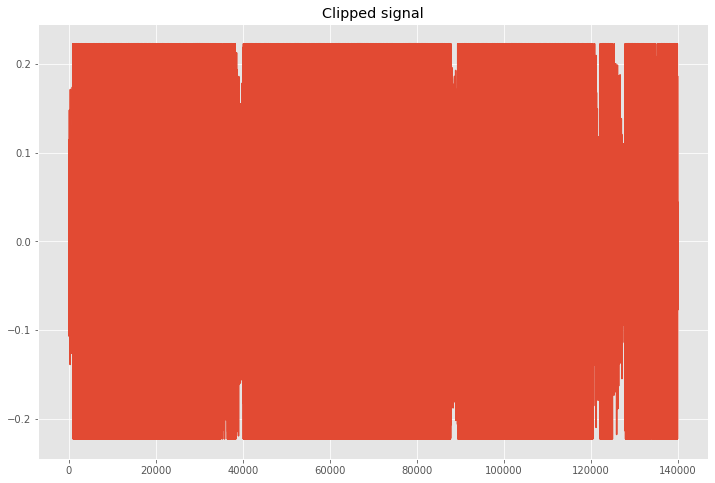

In [ ]:
# Clip the audio
clipped_audio , masks, clip_threshold, trueSDR, percentage = clip_sdr(music_n, inputSDR)

# See the clipped Audio
plt.figure(figsize=(12,8))
plt.title('Clipped signal')
plt.plot(clipped_audio)
Audio(clipped_audio, rate=samplerate)

In [ ]:
# Compute reliable data array
reliable_data = np.zeros(music.shape[0])
reliable_data[masks['Mr']] = clipped_audio[masks['Mr']]

clipped_data = np.zeros(music.shape[0])
clipped_data[masks['Mh']] = clip_threshold
clipped_data[masks['Ml']] = -clip_threshold

# Construction of the frame
from ltfatpy import gabwin, dgtreal, idgtreal
gabor_window = gabwin(wtype, a, M)
G_clip = dgtreal(clipped_audio.astype(float), gabor_window[0], a, M)[0]

gabor_analysis = lambda x: dgtreal(x,gabor_window[0],a,M)[0] # Return the first element
gabor_synthesis = lambda x: idgtreal(x,gabor_window[0],a,M,music.shape[0])[0] # Return the firs element only

shrink = {'type':'l',
          'lambda':1e-4,
          'mu':1,
          'glabel':'time',
          'neigh':1,
          'center':[1,1],
          'expo':2,
          'orth':0}
          
Gdeclip = np.zeros(G_clip.shape, dtype=np.complex128)
GdeclipZ = Gdeclip.copy()

number_lambdas = 20
inner_iterations = 500
delta = 1e-4
iter_cnt = 0

dSDR_process = [trueSDR]
data_rec = clipped_data.copy()

In [ ]:
for lambda_cnst in tqdm(np.logspace(-1, -4, number_lambdas)):
    shrink['lambda'] = lambda_cnst
    for k in range(1, inner_iterations):
        data_rec_old = data_rec.copy()
        iter_cnt = iter_cnt + 1
        # Forward step
        GdeclipOLD = Gdeclip.copy()
        xdeclipZ = gabor_synthesis(GdeclipZ)

        r1 = np.zeros(len(music))
        r1[masks['Mr']] = reliable_data[masks['Mr']] - xdeclipZ[masks['Mr']]
        grad1 = -gabor_analysis(r1)

        r2 = np.zeros((len(music)))
        r2[masks['Mh']] = clipped_data[masks['Mh']] - xdeclipZ[masks['Mh']]
        r2[masks['Ml']] = clipped_data[masks['Ml']] - xdeclipZ[masks['Ml']]
        r2[np.abs(xdeclipZ)>clip_threshold] = 0
        grad2 = -gabor_analysis(r2)


        GdeclipZ = GdeclipZ.copy() - grad1.copy() - grad2.copy() 
        # thresholding step
        Gdeclip = gen_threshold(GdeclipZ, shrink)
        # relaxation step
        # GdeclipZ = Gdeclip.copy() + 0.9 * (Gdeclip.copy() - GdeclipOLD.copy())
        GdeclipZ = Gdeclip.copy() + ( (k-1)/(k+5) * (Gdeclip.copy() - GdeclipOLD.copy()) )
        data_rec = gabor_synthesis(Gdeclip)
        if np.linalg.norm(data_rec_old - data_rec) < delta:
            break
    
    sdr_rec = sdr(music_n, data_rec)
    dSDR_process.append(sdr_rec)
    print('Lambda = {:.3f}, Iterations = {}, SDR = {:.3f}, dSDR = {:.3f}'.format(shrink['lambda'],iter_cnt, sdr_rec, sdr_rec-inputSDR ))
        

  5%|▌         | 1/20 [02:07<40:25, 127.67s/it]

Lambda = 0.100, Iterations = 499, SDR = 9.976, dSDR = 2.976


 10%|█         | 2/20 [03:44<32:49, 109.39s/it]

Lambda = 0.070, Iterations = 866, SDR = 11.118, dSDR = 4.118


 15%|█▌        | 3/20 [05:50<33:12, 117.18s/it]

Lambda = 0.048, Iterations = 1365, SDR = 12.574, dSDR = 5.574


 20%|██        | 4/20 [07:59<32:26, 121.65s/it]

Lambda = 0.034, Iterations = 1806, SDR = 13.960, dSDR = 6.960


 25%|██▌       | 5/20 [10:00<30:24, 121.65s/it]

Lambda = 0.023, Iterations = 2305, SDR = 15.063, dSDR = 8.063


 30%|███       | 6/20 [12:01<28:18, 121.31s/it]

Lambda = 0.016, Iterations = 2804, SDR = 15.816, dSDR = 8.816


 35%|███▌      | 7/20 [14:02<26:14, 121.10s/it]

Lambda = 0.011, Iterations = 3303, SDR = 16.378, dSDR = 9.378


 40%|████      | 8/20 [16:04<24:19, 121.60s/it]

Lambda = 0.008, Iterations = 3802, SDR = 16.679, dSDR = 9.679


 45%|████▌     | 9/20 [18:15<22:47, 124.31s/it]

Lambda = 0.005, Iterations = 4301, SDR = 16.846, dSDR = 9.846


 50%|█████     | 10/20 [20:24<20:59, 125.95s/it]

Lambda = 0.004, Iterations = 4800, SDR = 16.929, dSDR = 9.929


 55%|█████▌    | 11/20 [22:34<19:05, 127.26s/it]

Lambda = 0.003, Iterations = 5299, SDR = 16.982, dSDR = 9.982


 60%|██████    | 12/20 [24:44<17:04, 128.07s/it]

Lambda = 0.002, Iterations = 5798, SDR = 16.974, dSDR = 9.974


 65%|██████▌   | 13/20 [26:48<14:47, 126.72s/it]

Lambda = 0.001, Iterations = 6297, SDR = 16.953, dSDR = 9.953


 70%|███████   | 14/20 [28:47<12:26, 124.49s/it]

Lambda = 0.001, Iterations = 6796, SDR = 16.931, dSDR = 9.931


 75%|███████▌  | 15/20 [30:38<10:01, 120.23s/it]

Lambda = 0.001, Iterations = 7295, SDR = 16.922, dSDR = 9.922


 80%|████████  | 16/20 [32:30<07:51, 117.92s/it]

Lambda = 0.000, Iterations = 7794, SDR = 16.924, dSDR = 9.924


 85%|████████▌ | 17/20 [34:26<05:51, 117.33s/it]

Lambda = 0.000, Iterations = 8293, SDR = 16.919, dSDR = 9.919


 90%|█████████ | 18/20 [36:24<03:54, 117.49s/it]

Lambda = 0.000, Iterations = 8785, SDR = 16.915, dSDR = 9.915


 95%|█████████▌| 19/20 [38:09<01:53, 113.83s/it]

Lambda = 0.000, Iterations = 9241, SDR = 16.913, dSDR = 9.913


100%|██████████| 20/20 [39:57<00:00, 119.85s/it]

Lambda = 0.000, Iterations = 9716, SDR = 16.913, dSDR = 9.913


(0.1, 0.0001)

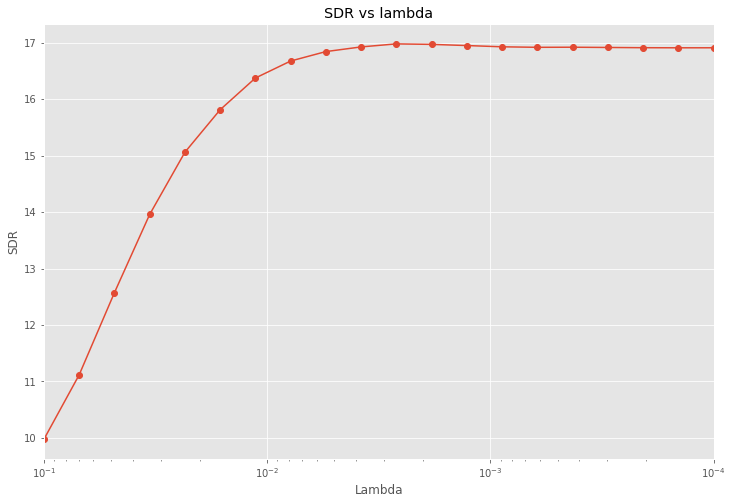

In [ ]:
# Plot the SDR improvement over lambda
plt.figure(figsize=(12,8))
plt.plot(np.logspace(-1, -4, number_lambdas), dSDR_process[1:], '-o')
plt.semilogx()
plt.title('SDR vs lambda')
plt.xlabel('Lambda')
plt.ylabel('SDR')
plt.xlim(1e-1, 1e-4)

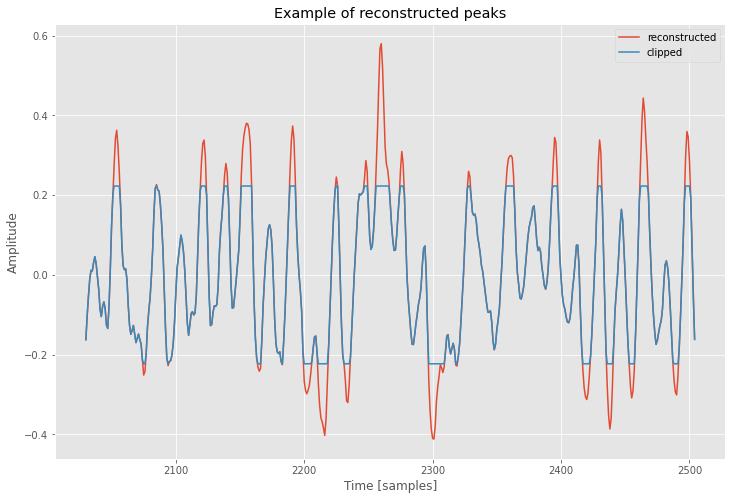

In [ ]:
indexes=[2030,2505]
plt.figure(figsize=(12,8))
plt.plot(np.arange(indexes[0],indexes[1]), data_rec[indexes[0]:indexes[1]], label='reconstructed')
plt.plot(np.arange(indexes[0],indexes[1]), clipped_audio[indexes[0]:indexes[1]], label='clipped')
# plt.ylim(9500,10010)
plt.title('Example of reconstructed peaks')
plt.xlabel('Time [samples]')
plt.ylabel('Amplitude')
plt.legend()

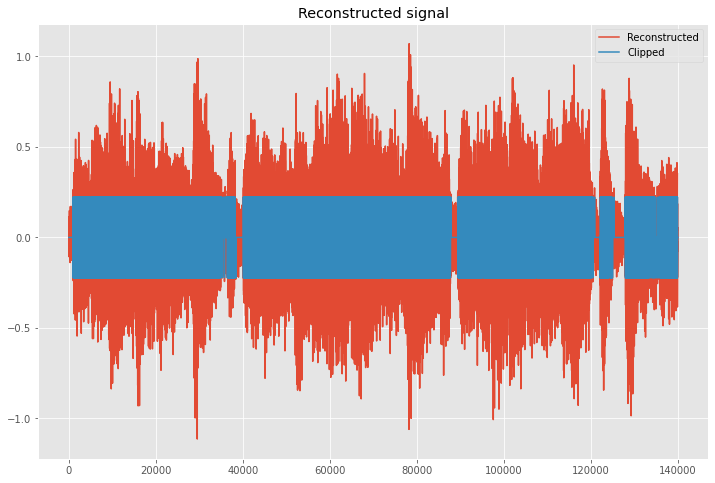

In [ ]:
# See the declipped Audio
plt.figure(figsize=(12,8))
plt.plot(data_rec, label='Reconstructed')
plt.plot(clipped_data, label='Clipped')
plt.title('Reconstructed signal')
Audio(data_rec, rate=samplerate)
plt.legend()